<a href="https://colab.research.google.com/github/rafalopes74/EnergyConsumptionAI/blob/main/multi_step_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [30]:
pip install comet_ml

In [31]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="Iy98TxnyEt52Fv5nugZ6muTmR",
    project_name="energy-consumption",
    workspace="ada-ferreira",
)

experiment.set_name("Multi-step Prediction")



plt.style.use('ggplot')

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: tensorboard, sklearn, tensorflow, keras. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/ada-ferreira/energy-consumption/213184dbdb2b4d489b5b84d7b9ceff1d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Test RMSE [3]  : (135.59858874161955, 2068.3133939689005)
COMET INFO:     Train RMSE [3] : (119.6009525223049, 2076.762793416903)
COMET INFO:   Others:
COMET INFO:     Name         : Multi-step Prediction
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=https%3A%2F%2Fgithub.com%2Frafalopes74%2FEnergyConsumptionAI%2Fblob%2Fmain%2Fmulti_

In [32]:
!wget --no-clobber https://raw.githubusercontent.com/rafalopes74/EnergyConsumptionAI/main/DAYTON_hourly.csv

File ‘DAYTON_hourly.csv’ already there; not retrieving.



In [33]:
data = pd.read_csv("/content/DAYTON_hourly.csv", header = 'infer', parse_dates = True)
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.set_index("Datetime")

data.resample('3H').sum()

,DAYTON_MW
Datetime,
2004-10-01 00:00:00,3157.0
2004-10-01 03:00:00,4423.0
2004-10-01 06:00:00,5486.0
2004-10-01 09:00:00,6209.0
2004-10-01 12:00:00,6450.0
...,...
2018-08-02 12:00:00,7269.0
2018-08-02 15:00:00,7796.0
2018-08-02 18:00:00,7778.0


In [34]:
data.shape

(121275, 1)

In [35]:
data.tail(5)

,DAYTON_MW
Datetime,
2018-01-01 20:00:00,2732.0
2018-01-01 21:00:00,2724.0
2018-01-01 22:00:00,2664.0
2018-01-01 23:00:00,2614.0
2018-01-02 00:00:00,2552.0


In [36]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)

In [37]:
train, test = train_test_split(normalized_data, test_size = 0.2, shuffle = False)
print(len(data), len(train), len(test))

121275 97020 24255


  Hyper parameters

In [38]:
n_steps_out = 8
lag = 8

n_steps_in = 32
n_epochs = 9
learn_rate = 0.0002
batch_size = 1

params = {
  "Steps" : n_steps_in,
  "Epochs" : n_epochs,
  "Learn rate" : learn_rate,
  "Batch size" : batch_size
}

experiment.log_parameters(params)

Model

In [39]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, 1)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))

my_optimizer = Adam(lr=learn_rate)
model.compile(optimizer=my_optimizer, loss='mse')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [40]:
def split_sequence(sequence, n_steps_in, n_steps_out, lag = 0):
  X, y = list(), list()
  i = 0
  while i < len(sequence):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out

    # check if we are beyond the sequence
    if out_end_ix + lag > len(sequence):
      break

    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix + lag:out_end_ix + lag]
    i = i + n_steps_out
    X.append(seq_x)
    y.append(seq_y)
  
  return np.array(X), np.array(y)

In [41]:
seq = [0, 1, 2, 3, 4, 5, 6, 7, 8]
input, output = split_sequence(seq, n_steps_in = 4, n_steps_out = 2, lag = 1)

print(input)
print()
print(output)

[[0 1 2 3]
 [2 3 4 5]]

[[5 6]
 [7 8]]


In [42]:
# split into samples
trainX, trainY = split_sequence(train, n_steps_in, n_steps_out)
testX, testY = split_sequence(test, n_steps_in, n_steps_out)

trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
testX = testX.reshape((testX.shape[0], testX.shape[1], 1))

In [43]:
%%time
summary = model.fit(trainX, trainY, epochs=n_epochs, batch_size=batch_size)

Epoch 1/9
12123/12123 [==============================] - 126s 10ms/step - loss: 0.0106
Epoch 2/9
12123/12123 [==============================] - 108s 9ms/step - loss: 0.0039
Epoch 3/9
12123/12123 [==============================] - 106s 9ms/step - loss: 0.0032
Epoch 4/9
12123/12123 [==============================] - 107s 9ms/step - loss: 0.0028
Epoch 5/9
12123/12123 [==============================] - 106s 9ms/step - loss: 0.0025
Epoch 6/9
12123/12123 [==============================] - 107s 9ms/step - loss: 0.0023
Epoch 7/9
12123/12123 [==============================] - 107s 9ms/step - loss: 0.0021
Epoch 8/9
12123/12123 [==============================] - 106s 9ms/step - loss: 0.0020
Epoch 9/9
12123/12123 [==============================] - 107s 9ms/step - loss: 0.0020
CPU times: user 25min 25s, sys: 1min 20s, total: 26min 45s
Wall time: 16min 20s


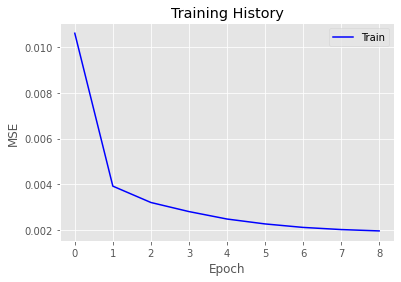

In [44]:
plt.plot(summary.history['loss'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [45]:
trainPredict = model.predict(trainX, verbose=0)
testPredict = model.predict(testX, verbose=0)

In [46]:
trainRMSE = np.sqrt(mean_squared_error(trainY.flatten(), trainPredict.flatten()))
print('Train Score:')
print('   %.3f RMSE' % (trainRMSE))

testRMSE = np.sqrt(mean_squared_error(testY.flatten(), testPredict.flatten()))
print('Test Score:')
print('   %.3f RMSE' % (testRMSE))


params = {
  "Train RMSE" : trainRMSE,
  "Test RMSE" : testRMSE
}

experiment.log_metrics(params)

Train Score:
   0.044 RMSE
Test Score:
   0.055 RMSE


Performance

In [47]:
# invert predictions
descaled_trainPredict = scaler.inverse_transform(trainPredict.reshape(-1,1))
descaled_trainY = scaler.inverse_transform(trainY.reshape(-1,1))
descaled_testPredict = scaler.inverse_transform(testPredict.reshape(-1,1))
descaled_testY = scaler.inverse_transform(testY.reshape(-1,1))

In [48]:
trainRMSE = np.sqrt(mean_squared_error(descaled_trainY.flatten(), descaled_trainPredict.flatten()))
print('Train Score:')
print('   %.3f RMSE' % (trainRMSE))

testRMSE = np.sqrt(mean_squared_error(descaled_testY.flatten(), descaled_testPredict.flatten()))
print('Test Score:')
print('   %.3f RMSE' % (testRMSE))

Train Score:
   121.007 RMSE
Test Score:
   151.977 RMSE


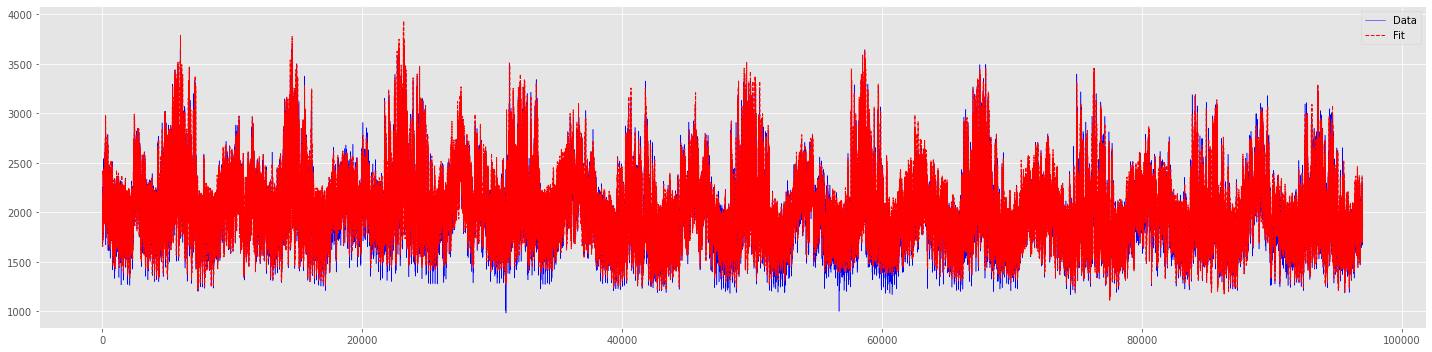

In [49]:
# Compare the training prediction

plt.figure(figsize = (20, 5))

plt.plot(descaled_trainY.flatten(), c='b',linewidth=0.5, linestyle="-",label="Data")
plt.plot(descaled_trainPredict.flatten(), c='r',linewidth=1, linestyle="--",label="Fit")

plt.legend()
plt.tight_layout()
plt.show()

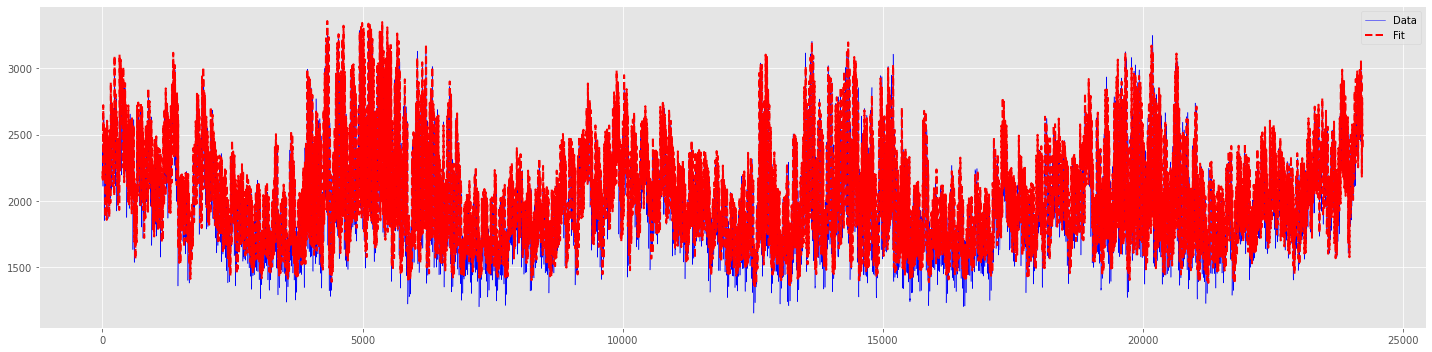

In [50]:
# Compare the test prediction

plt.figure(figsize = (20, 5))

plt.plot(descaled_testY.flatten()[:], c='b',linewidth=0.5, linestyle="-",label="Data")
plt.plot(descaled_testPredict.flatten()[:], c='r',linewidth=2, linestyle="--",label="Fit")

plt.legend()
plt.tight_layout()
plt.show()